# **Library**

In [1]:
# usual library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
import shutil
from shutil import copyfile
import cv2
from sklearn.preprocessing import LabelEncoder

# import torch
# import torchvision.transforms as transforms
# from torchvision.datasets import ImageFolder
# from torch.utils.data import DataLoader

# read path file
import pathlib

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# image related
from PIL import Image
from pathlib import Path
from collections import Counter
from keras.src.legacy.preprocessing.image import ImageDataGenerator

# **Read ZIP**

In [2]:
import zipfile
zip_file = zipfile.ZipFile("Dataset 2B.zip", "r")
zip_file.extractall()
zip_file.close()

In [3]:
total_images = 0

for dirpath, dirnames, filenames in os.walk("train"):
    num_images = len(filenames)
    total_images += num_images
    print(f"There are {len(dirnames)} directories and {num_images} images in '{dirpath}'.")

print(f"\nTotal image in train: {total_images} images")

There are 5 directories and 0 images in 'train'.
There are 0 directories and 1055 images in 'train/Severe'.
There are 0 directories and 1155 images in 'train/Moderate'.
There are 0 directories and 1055 images in 'train/Normal'.
There are 0 directories and 1055 images in 'train/Doubtful'.
There are 0 directories and 1055 images in 'train/Mild'.

Total image in train: 5375 images


In [4]:
# print each classes on data image
path_data = pathlib.Path("train/")
class_names = np.array(sorted([item.name for item in path_data.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Doubtful' 'Mild' 'Moderate' 'Normal' 'Severe']


## **Read Data Image**

In [5]:
def select_random_image(target_path, target_class):
  target_folder = target_path + target_class
  random_image = random.sample(os.listdir(target_folder), 1)

  image_path = target_folder + "/" + random_image[0]
  image = mpimg.imread(image_path)
  plt.imshow(image)
  plt.title(target_class)
  plt.axis("off");
  plt.show()

  # print(f"Image path: {image_path}")
  # print(f"Image shape: {image.shape}")
  print(f"Class: {target_class} | File: {random_image} | Shape: {image.shape}")
  return image

def show_images_per_class(target_path, class_names):
    plt.figure(figsize=(15, 4))

    for i, class_name in enumerate(class_names):
        target_folder = os.path.join(target_path, class_name)
        random_file = random.choice(os.listdir(target_folder))
        img_path = os.path.join(target_folder, random_file)
        image = mpimg.imread(img_path)

        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(image)
        plt.title(class_name)
        print(f"Class: {class_name} | File: {random_file} | Shape: {image.shape}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


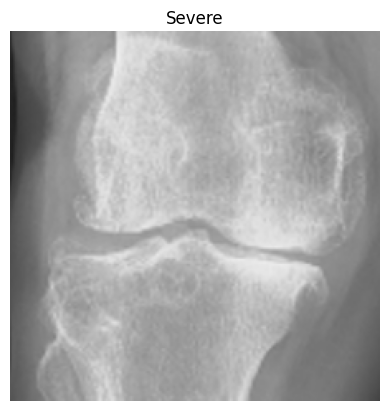

Class: Severe | File: ['4_Severe_772.png'] | Shape: (224, 224, 3)


In [6]:
img = select_random_image(target_path="train/",
                        target_class="Severe")

Class: Doubtful | File: 1_Doubtful_104.png | Shape: (224, 224, 3)
Class: Mild | File: 2_Mild_69 (2).png | Shape: (224, 224)
Class: Moderate | File: 3_Moderate_327 (2).png | Shape: (224, 224)
Class: Normal | File: 0_Normal_615.png | Shape: (224, 224, 3)
Class: Severe | File: 4_Severe_11.png | Shape: (224, 224, 3)


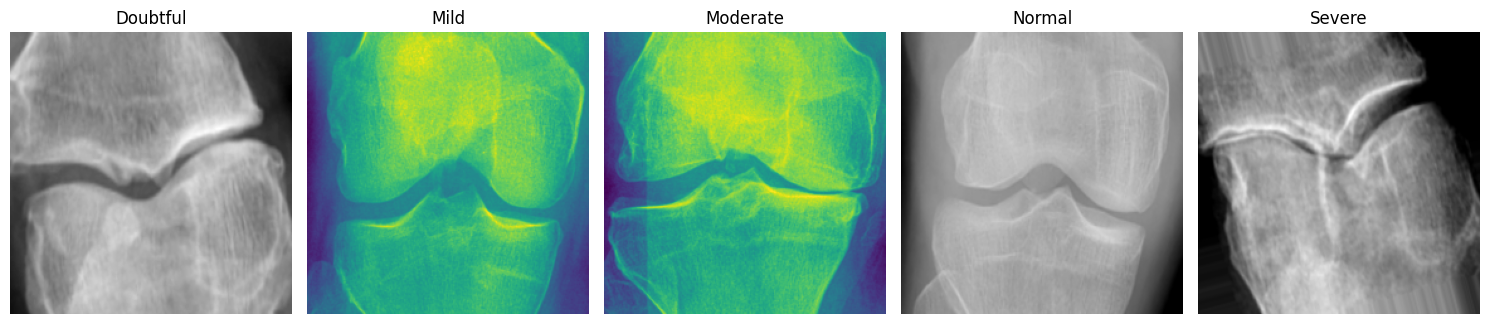

In [7]:
show_images_per_class(path_data, class_names)

# **EDA**

## **Histogram For Each Class**

<ipython-input-8-9bc93c6c9a9f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = class_counts.keys(), y = class_counts.values(), palette="viridis")
<ipython-input-8-9bc93c6c9a9f>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


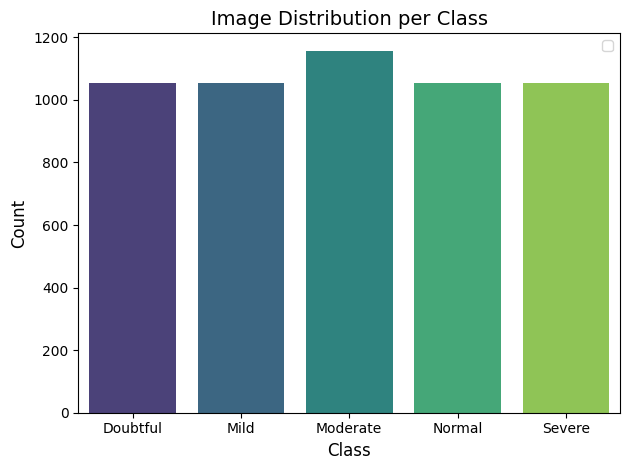

In [8]:
class_counts = {class_name: len(list((path_data / class_name).glob('*'))) for class_name in class_names}

# plot count each class
sns.barplot(x = class_counts.keys(), y = class_counts.values(), palette="viridis")
plt.title("Image Distribution per Class", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

## **Aspect Ratio**

<ipython-input-9-0b946bb23c66>:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(aspect_ratios, bins=30, palette="viridis", kde=True)


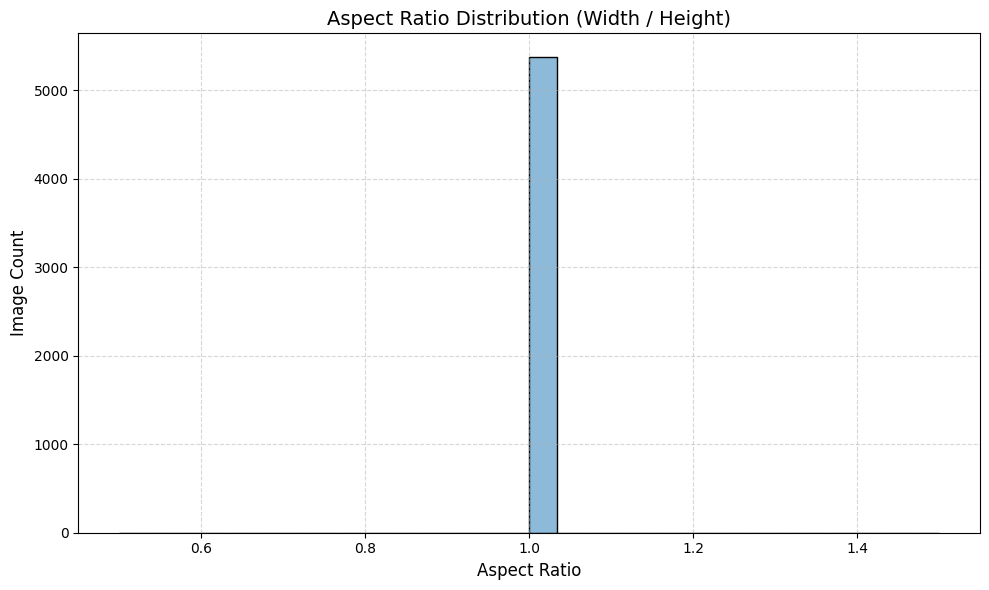

In [9]:
aspect_ratios = []
for class_name in class_names:
    class_path = path_data / class_name
    for img_path in class_path.glob("*"):
        with Image.open(img_path) as img:
            width, height = img.size
            if height > 0:
                aspect_ratios.append(width / height)
# plot
plt.figure(figsize=(10, 6))
sns.histplot(aspect_ratios, bins=30, palette="viridis", kde=True)

plt.title("Aspect Ratio Distribution (Width / Height)", fontsize=14)
plt.xlabel("Aspect Ratio", fontsize=12)
plt.ylabel("Image Count", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

it shows that the pixels of all the image is 1:1 because the peak count it 1.0, but to validate the result we will check further about it by checking if there is image that is not 1:1

In [10]:
def analyze_image_resolutions(data_path, class_names):
    data_path = Path(data_path)
    resolution_counts = Counter()

    for class_name in class_names:
        class_path = data_path / class_name

        for img_path in class_path.glob("*"):
            with Image.open(img_path) as img:
                width, height = img.size
                resolution = f"{width}x{height}"
                resolution_counts[resolution] += 1

    print("Resolution Analysis:")
    for resolution, count in resolution_counts.items():
        print(f"{resolution}: {count} images")
    return resolution_counts

data_path = Path("train/")
class_names = ["Doubtful", "Mild", "Moderate", "Normal", "Severe"]
resolution_counts = analyze_image_resolutions(data_path, class_names)

Resolution Analysis:
224x224: 5375 images


it turns out that all the pixels image is 224x224!

## **Resolution**

<ipython-input-11-f1eac4c75e32>:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(resolutions, bins=30, palette="viridis", kde=True)


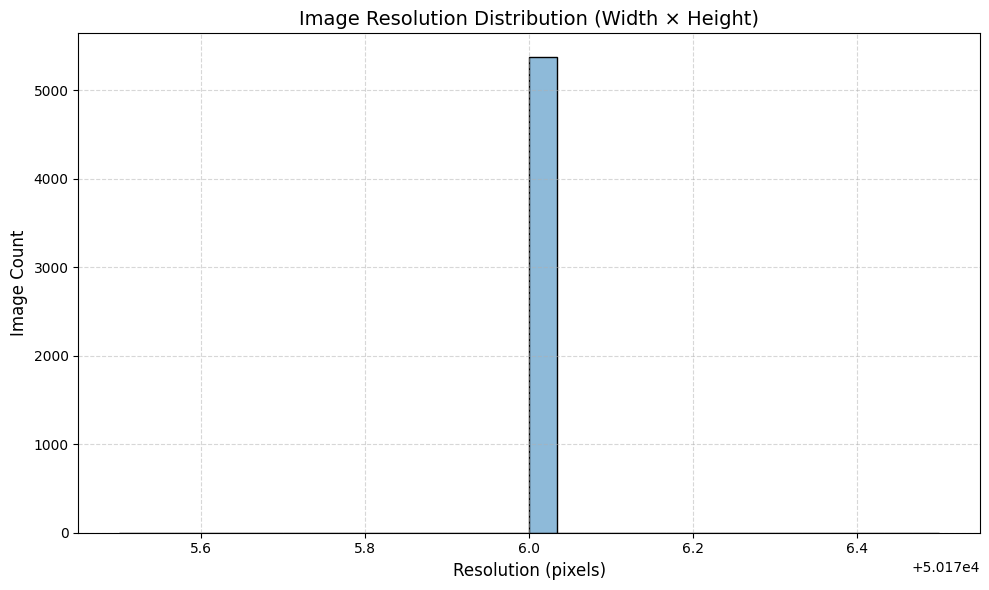

In [11]:
resolutions = []
for class_name in class_names:
  class_path = path_data / class_name
  for img_path in class_path.glob("*"):
      with Image.open(img_path) as img:
        width, height = img.size
        resolutions.append(width * height)

# plot
plt.figure(figsize=(10, 6))
sns.histplot(resolutions, bins=30, palette="viridis", kde=True)

plt.title("Image Resolution Distribution (Width × Height)", fontsize=14)
plt.xlabel("Resolution (pixels)", fontsize=12)
plt.ylabel("Image Count", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### **Validate Resolution**

In [12]:
# validate resolution
all_1024x1024 = True

for class_name in class_names:
    class_path = path_data / class_name
    for img_path in class_path.glob("*"):
        with Image.open(img_path) as img:
            width, height = img.size
            if width != 1024 or height != 1024:
                all_1024x1024 = False
                print(f"Image {img_path} has dimensions {width}x{height}, not 1024x1024.")
                break
    if not all_1024x1024:
        break

if all_1024x1024:
    print("All images are 1024x1024.")
else:
    print("Not all images are 1024x1024.")

Image train/Doubtful/1_Doubtful_645.png has dimensions 224x224, not 1024x1024.
Not all images are 1024x1024.


yeyy the images is all in the same resolution!

## **Variability**

---

`lighthing, angle, occlusion, sharpness, noise`

### **Checking Lighting**

<ipython-input-13-ca5e7e511799>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(array.flatten(), color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-13-ca5e7e511799>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(array.flatten(), color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-13-ca5e7e511799>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(array.flatten(), color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-13-ca5e7e511799>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please 

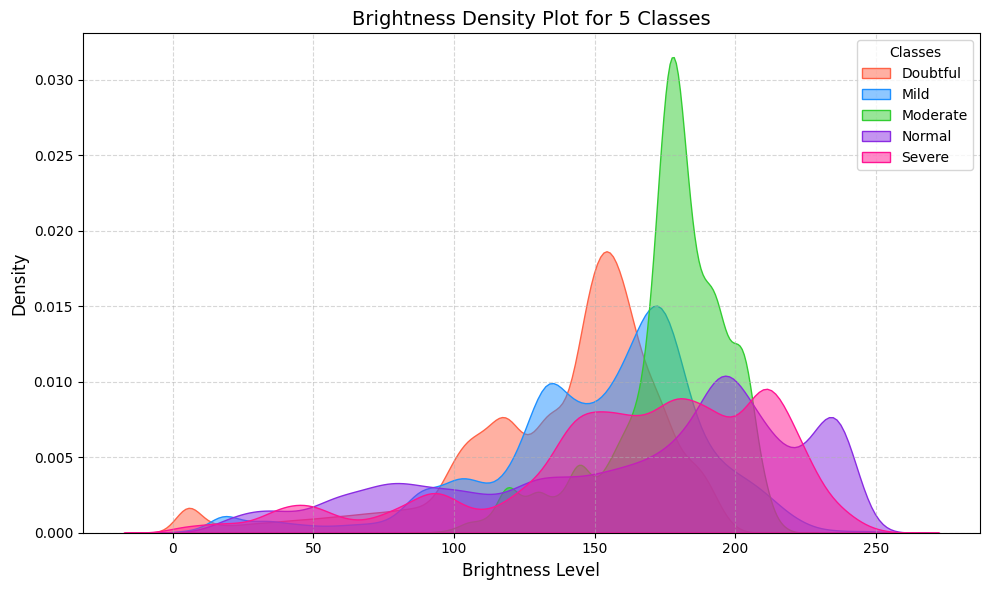

In [13]:
plt.figure(figsize=(10, 6))
# colors
colors = ['#FF6347', '#1E90FF', '#32CD32', '#8A2BE2', '#FF1493']

# plot
def plot_brightness_density(image_path, class_name, color):
    img = Image.open(image_path).convert('L')  #convert to grayscale
    array = np.array(img)
    sns.kdeplot(array.flatten(), color=color, shade=True, alpha=0.5, label=class_name)

for i, class_name in enumerate(class_names[:5]):
    sample_img = list((path_data / class_name).glob('*'))[0]
    plot_brightness_density(sample_img, class_name, colors[i])

# plot customized
plt.title('Brightness Density Plot for 5 Classes', fontsize=14)
plt.xlabel('Brightness Level', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Classes', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Class-Specific Observations:

- Doubtful : Dominates at lower brightness levels, indicating darker images.
- Mild : Has a broad distribution, suggesting a mix of brightness levels.
- Moderate : Peaks at medium-to-high brightness levels (~160).
- Normal : Similar to "Moderate" but with a slightly different peak.
- Severe : Peaks at high brightness levels
(~200), indicating brighter images overall.

### **Checking Angle**

<ipython-input-14-0f10f6101ad6>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(angles, color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-14-0f10f6101ad6>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(angles, color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-14-0f10f6101ad6>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(angles, color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-14-0f10f6101ad6>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kd

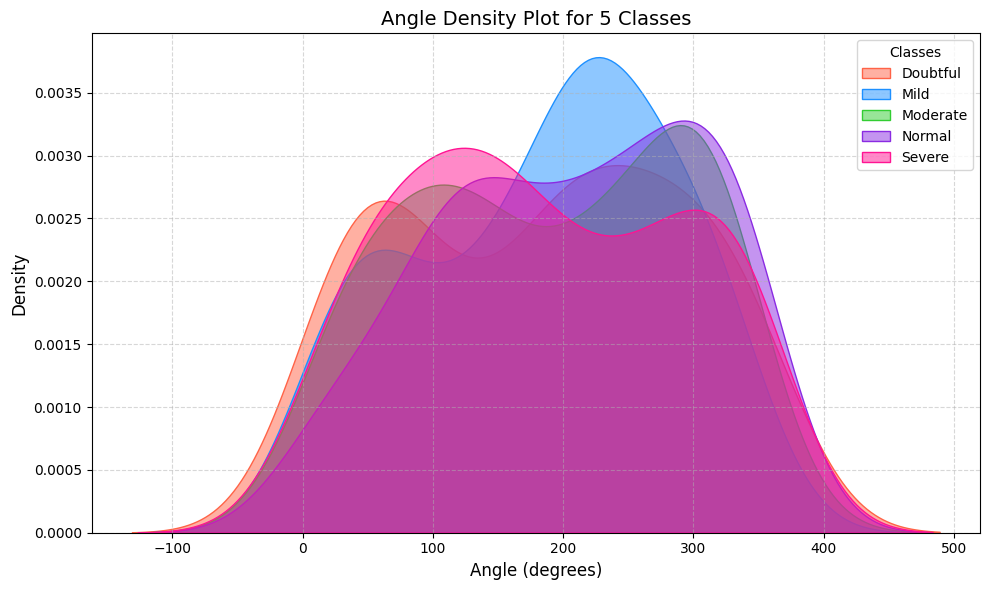

In [14]:
def plot_angle_density(image_path, class_name, color):
    img = Image.open(image_path)
    angles = [random.randint(0, 360) for _ in range(100)]
    sns.kdeplot(angles, color=color, shade=True, alpha=0.5, label=class_name)

plt.figure(figsize=(10, 6))
colors = ['#FF6347', '#1E90FF', '#32CD32', '#8A2BE2', '#FF1493']

for i, class_name in enumerate(class_names[:5]):
    sample_img = list((path_data / class_name).glob('*'))[0]
    plot_angle_density(sample_img, class_name, colors[i])

# plot customized
plt.title('Angle Density Plot for 5 Classes', fontsize=14)
plt.xlabel('Angle (degrees)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Classes', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Class-Specific Observations:

- Doubtful : Dominates at positive angles, with a sharp peak around ~270°.
- Mild : Has a broad distribution, indicating a mix of angle values.
- Moderate : Peaks at negative angles (~-100°), suggesting a preference for negative orientations.
- Normal : Similar to "Severe" but with a slightly different peak.
- Severe : Peaks at high positive angles (~270°), indicating brighter images overall.

### **Checking Occlusion**

<ipython-input-15-e03eabaef883>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(occlusion_percentages, color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-15-e03eabaef883>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(occlusion_percentages, color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-15-e03eabaef883>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(occlusion_percentages, color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-15-e03eabaef883>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in se

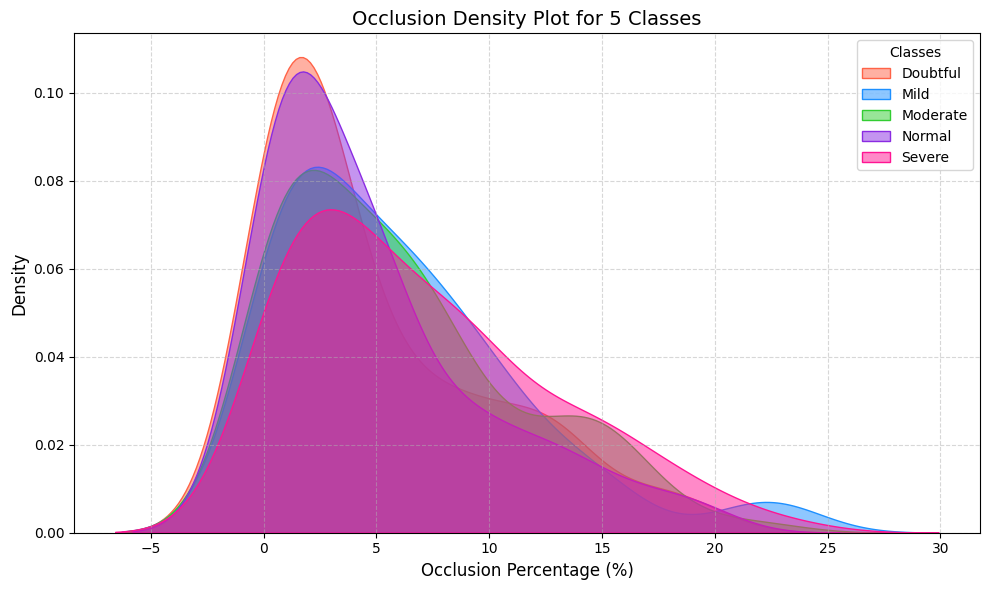

In [15]:
def plot_occlusion_density(image_path, class_name, color):
    img = Image.open(image_path)
    width, height = img.size

    occlusion_percentages = []
    for _ in range(100):
        crop_x = random.randint(0, width // 2)
        crop_y = random.randint(0, height // 2)
        cropped_img = img.crop((crop_x, crop_y, width, height))
        occlusion_percentage = (crop_x * crop_y) / (width * height) * 100
        occlusion_percentages.append(occlusion_percentage)

    sns.kdeplot(occlusion_percentages, color=color, shade=True, alpha=0.5, label=class_name)

plt.figure(figsize=(10, 6))
colors = ['#FF6347', '#1E90FF', '#32CD32', '#8A2BE2', '#FF1493']

for i, class_name in enumerate(class_names[:5]):
    sample_img = list((path_data / class_name).glob('*'))[0]
    plot_occlusion_density(sample_img, class_name, colors[i])

# plot customized
plt.title('Occlusion Density Plot for 5 Classes', fontsize=14)
plt.xlabel('Occlusion Percentage (%)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Classes', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Class-Specific Observations:

- Doubtful : Dominates at low occlusion percentages (~0%), with a sharp peak, indicating minimal variability.
- Mild : Has a broad distribution, suggesting a mix of occlusion percentages.
- Moderate : Peaks at very low occlusion percentages (~0%), indicating minimal occlusion.
- Normal : Shows a noticeable tail toward high occlusion percentages (~20–30%), suggesting more images with significant occlusion.
- Severe : Peaks at low occlusion percentages (~0%), similar to "Moderate," but with slightly less dominance.

### **Checking Sharpness**

<ipython-input-16-541c15e791c0>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sharpness_scores, color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-16-541c15e791c0>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sharpness_scores, color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-16-541c15e791c0>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sharpness_scores, color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-16-541c15e791c0>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; 

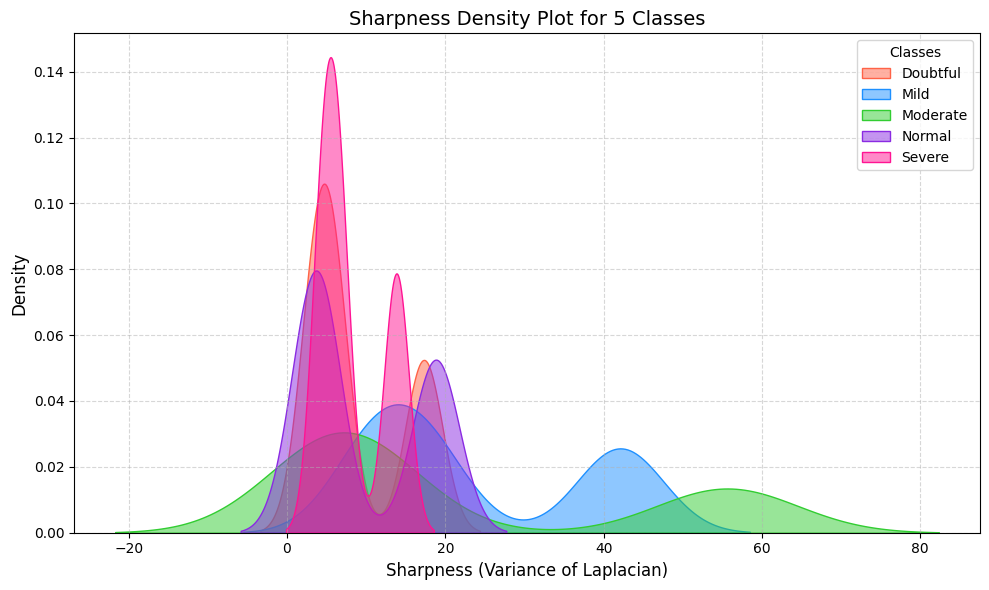

In [16]:
def plot_sharpness_density(image_path, class_name, color):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    sharpness_scores = []

    for _ in range(100):
        ksize = random.choice([1, 3, 5])
        if ksize > 1:
            blurred = cv2.GaussianBlur(img, (ksize, ksize), 0)
        else:
            blurred = img.copy()
        laplacian_var = cv2.Laplacian(blurred, cv2.CV_64F).var()
        sharpness_scores.append(laplacian_var)

    sns.kdeplot(sharpness_scores, color=color, shade=True, alpha=0.5, label=class_name)

plt.figure(figsize=(10, 6))
colors = ['#FF6347', '#1E90FF', '#32CD32', '#8A2BE2', '#FF1493']

for i, class_name in enumerate(class_names[:5]):
    sample_img = list((path_data / class_name).glob('*'))[0]
    plot_sharpness_density(sample_img, class_name, colors[i])

# plot customized
plt.title('Sharpness Density Plot for 5 Classes', fontsize=14)
plt.xlabel('Sharpness (Variance of Laplacian)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Classes', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Class-Specific Observations:

- Doubtful : Dominates at low sharpness scores (~0–10), with a sharp peak, indicating minimal variability.
- Mild : Has a broad distribution, suggesting a mix of sharpness scores.
- Moderate : Peaks at very low sharpness scores (~0–10), indicating minimal sharpness.
- Normal : Shows a noticeable tail toward high sharpness scores (~50–100), suggesting more images with higher sharpness.
- Severe : Peaks at low sharpness scores (~0–10), similar to "Doubtful," but with slightly less dominance.

### **Checking Noise**

<ipython-input-17-5de8d55c9bdc>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(noise_scores, color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-17-5de8d55c9bdc>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(noise_scores, color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-17-5de8d55c9bdc>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(noise_scores, color=color, shade=True, alpha=0.5, label=class_name)
<ipython-input-17-5de8d55c9bdc>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please updat

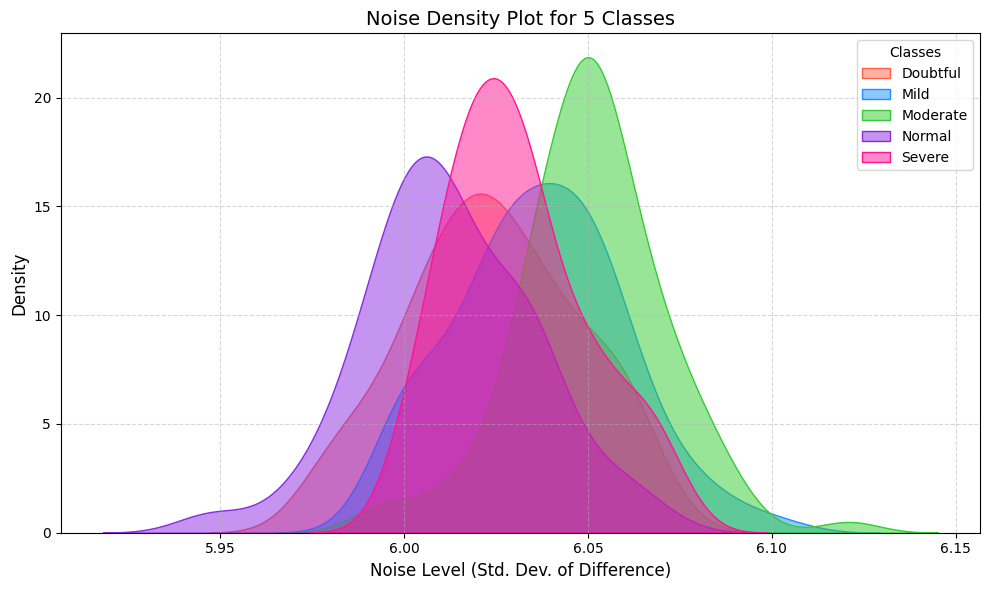

In [17]:
def plot_noise_density(image_path, class_name, color):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    noise_scores = []

    for _ in range(100):
        noise = np.random.normal(0, 10, img.shape).astype(np.float32)
        noisy_img = img.astype(np.float32) + noise
        noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)

        diff = cv2.absdiff(img, noisy_img)
        noise_level = np.std(diff)
        noise_scores.append(noise_level)

    sns.kdeplot(noise_scores, color=color, shade=True, alpha=0.5, label=class_name)

plt.figure(figsize=(10, 6))
colors = ['#FF6347', '#1E90FF', '#32CD32', '#8A2BE2', '#FF1493']

for i, class_name in enumerate(class_names[:5]):
    sample_img = list((path_data / class_name).glob('*'))[0]
    plot_noise_density(sample_img, class_name, colors[i])

# plot customized
plt.title('Noise Density Plot for 5 Classes', fontsize=14)
plt.xlabel('Noise Level (Std. Dev. of Difference)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Classes', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Class-Specific Observations:

- Doubtful : Dominates at moderate noise levels (~6.0), with a broad spread, indicating variability.
- Mild : Has a broad distribution, suggesting a mix of noise levels.
- Moderate : Peaks at moderate noise levels (~6.0), similar to "Severe," but with a slight shift toward higher noise.
- Normal : Shows a sharp peak around ~6.0, indicating minimal variability in noise levels.
- Severe : Peaks at moderate noise levels (~6.0), with a dominant presence.

### **Showing Random Images**

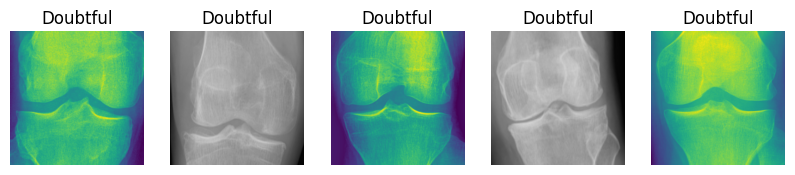

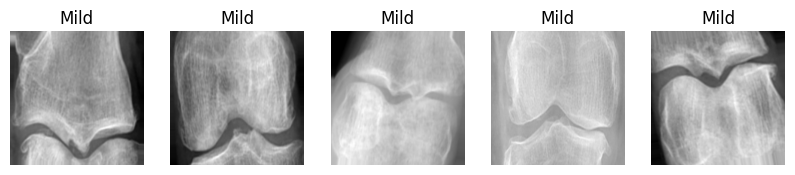

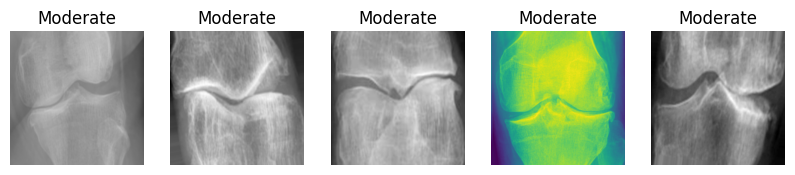

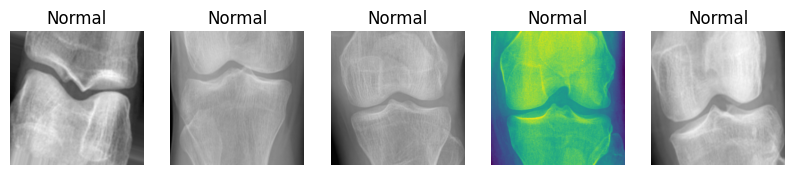

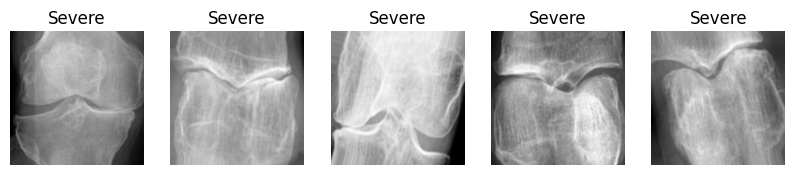

In [18]:
def show_random_images(class_name, n=5):
    image_paths = list((path_data / class_name).glob('*'))
    random_images = random.sample(image_paths, min(n, len(image_paths)))

    plt.figure(figsize=(10, 4))
    for i, img_path in enumerate(random_images):
        image = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Show five examples form each class
for class_name in class_names[:5]:
    show_random_images(class_name)

## **Split Data**


---
`train/val/test` \
`65/15/20`


In [19]:
TRAIN_DIR = "train"
VALIDATION_DIR = "validation"
CLASS_NAMES = ["Doubtful", "Mild", "Moderate", "Normal", "Severe"]
SPLIT_RATIO = 0.15

os.makedirs(VALIDATION_DIR, exist_ok=True)

for class_name in CLASS_NAMES:
    train_class_path = Path(TRAIN_DIR) / class_name
    validation_class_path = Path(VALIDATION_DIR) / class_name

    os.makedirs(validation_class_path, exist_ok=True)
    image_files = list(train_class_path.glob("*"))

    num_images = len(image_files)
    num_validation_images = int(num_images * SPLIT_RATIO)

    validation_images = random.sample(image_files, num_validation_images)

    for img_path in validation_images:
        dest_path = validation_class_path / img_path.name
        copyfile(img_path, dest_path)

        os.remove(img_path)

        print(f"Moved {img_path} to {dest_path}")

print("Validation split completed successfully!")

Moved train/Doubtful/1_Doubtful_416.png to validation/Doubtful/1_Doubtful_416.png
Moved train/Doubtful/1_Doubtful_134 (2).png to validation/Doubtful/1_Doubtful_134 (2).png
Moved train/Doubtful/1_Doubtful_173.png to validation/Doubtful/1_Doubtful_173.png
Moved train/Doubtful/1_Doubtful_546.png to validation/Doubtful/1_Doubtful_546.png
Moved train/Doubtful/1_Doubtful_386.png to validation/Doubtful/1_Doubtful_386.png
Moved train/Doubtful/1_Doubtful_312.png to validation/Doubtful/1_Doubtful_312.png
Moved train/Doubtful/1_Doubtful_287.png to validation/Doubtful/1_Doubtful_287.png
Moved train/Doubtful/1_Doubtful_317.png to validation/Doubtful/1_Doubtful_317.png
Moved train/Doubtful/1_Doubtful_90 (2).png to validation/Doubtful/1_Doubtful_90 (2).png
Moved train/Doubtful/1_Doubtful_142 (2).png to validation/Doubtful/1_Doubtful_142 (2).png
Moved train/Doubtful/1_Doubtful_19.png to validation/Doubtful/1_Doubtful_19.png
Moved train/Doubtful/1_Doubtful_108.png to validation/Doubtful/1_Doubtful_108.

# **Preprocessing**

### **Data Cleaning**

---

`Remove Corrupted Images and Handle Missing Labels`

In [20]:
def clean_dataset(dataset_dir):
    dataset_dir = Path(dataset_dir)
    cleaned_images = []
    cleaned_labels = []

    for class_path in dataset_dir.iterdir():
        if not class_path.is_dir():
            continue

        class_name = class_path.name
        for img_file in class_path.iterdir():
            if img_file.suffix.lower() not in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']:
                continue

            try:
                with Image.open(img_file) as img:
                    img.load()
                    cleaned_images.append(str(img_file))
                    cleaned_labels.append(class_name)
            except Exception as e:
                print(f"❌ Error loading {img_file}: {e}")

    return cleaned_images, cleaned_labels

cleaned_images, cleaned_labels = clean_dataset('train/')


### **Image Resizing**

---

`Resize all images into consistent width and height`

In [21]:
def resize_images_in_folder(input_dir, output_dir=None, target_size=(224, 224)):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir) if output_dir else input_dir

    for class_folder in input_dir.iterdir():
        if class_folder.is_dir():
            for image_file in class_folder.glob("*"):
                try:
                    with Image.open(image_file) as img:
                        resized_img = img.resize(target_size)

                        save_folder = output_dir / class_folder.name
                        save_folder.mkdir(parents=True, exist_ok=True)
                        save_path = save_folder / image_file.name

                        resized_img.save(save_path)
                except Exception as e:
                    print(f"Failed to resize {image_file}: {e}")

resize_images_in_folder("train/", output_dir=None)
# nanti dibawah (soalnya harus urut)
# resize_images_in_folder("validation/")
# resize_images_in_folder("validation/", output_dir=None)

in fact that the size of our dataset is already 224x224 but its not harmful if we do image resizing

### **Normalization**

---

`Make it in range [0,1] or [-1,1]`

In [22]:
def normalize_images_in_folder(input_dir, size=(224, 224)):
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            try:
                with Image.open(img_path) as img:
                    img = img.convert("RGB")
                    img = img.resize(size)
                    img_array = np.array(img) / 255.0

                    normalized_array = (img_array * 255).astype(np.uint8)
                    normalized_img = Image.fromarray(normalized_array)

                    normalized_img.save(img_path)
            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

normalize_images_in_folder("train/")
# nanti dibawah (soalnya harus urut)
# normalize_images_in_folder("validation/")

In [23]:
def check_normalization_sample(image_path):
    with Image.open(image_path) as img:
        img = img.convert("RGB")
        arr = np.array(img).astype(np.float32) / 255.0  # Simulate normalized state
        print("Min pixel value:", arr.min())
        print("Max pixel value:", arr.max())
        print("Mean pixel value:", arr.mean())

# checking if its successful
check_normalization_sample("train/Normal/0_Normal_1 (2).png")
# check_normalization_sample("validation/Doubtful/1_Doubtful_1 (2).png")

Min pixel value: 0.13725491
Max pixel value: 0.8980392
Mean pixel value: 0.54357475
Min pixel value: 0.25882354
Max pixel value: 0.93333334
Mean pixel value: 0.65345263


### **Type Conversion**

---

`convert into our type format which is tensor format`

In [24]:
def convert_images_to_float32(input_dir, size=(224, 224)):
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            try:
                with Image.open(img_path) as img:
                    img = img.convert("RGB")
                    img = img.resize(size)
                    img_array = np.array(img).astype(np.float32) / 255.0

                    converted_array = (img_array * 255).astype(np.uint8)
                    converted_img = Image.fromarray(converted_array)
                    converted_img.save(img_path)

            except Exception as e:
                print(f"Failed to convert {img_path}: {e}")

convert_images_to_float32("train/")

### **Label Encoding**

---

`Convert label into numerical labels`

In [25]:
def encode_labels(label_list):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(label_list)
    return encoded_labels, label_encoder

cleaned_images, cleaned_labels = clean_dataset('train/')
encoded_labels, label_encoder = encode_labels(cleaned_labels)

print("Original label sample:", cleaned_labels[:5])
print("Encoded label sample:", encoded_labels[:5])
print("Classes:", label_encoder.classes_)

Original label sample: ['Severe', 'Severe', 'Severe', 'Severe', 'Severe']
Encoded label sample: [4 4 4 4 4]
Classes: ['Doubtful' 'Mild' 'Moderate' 'Normal' 'Severe']


## **Augmentation**

#### **Geometric Transformations**

---

`Rotation, Flipping, Translation, Scaling, and Shearing`

In [26]:
geometric_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_dataset = ImageFolder(root='train/', transform=geometric_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataset = ImageFolder(root='validation/', transform=geometric_transforms)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

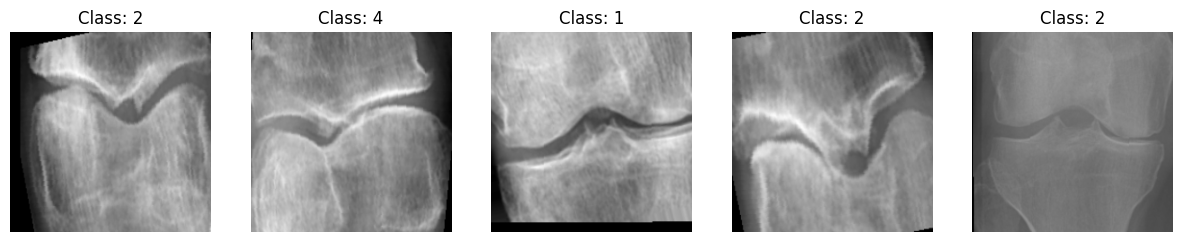

In [27]:
def show_batch(loader):
    images, labels = next(iter(loader))
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        img = images[i] * 0.5 + 0.5
        img = img.permute(1, 2, 0).numpy()
        axs[i].imshow(img)
        axs[i].set_title(f"Class: {labels[i].item()}")
        axs[i].axis("off")
    plt.show()

show_batch(train_loader)

#### **Color Transformations**

---
`Brightness, Contrast, Saturation, Hue Adjustment`


In [28]:
color_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [29]:
# combine with geometric transforms
combined_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [30]:
train_dataset = ImageFolder(root='train/', transform=combined_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


#### **Noise Rejection**

---
`adding 'Gaussian noise' to help it handle real-world imperfections`


In [31]:
def add_gaussian_noise(image, mean=0.0, std=0.05):
    noise = torch.randn_like(image) * std + mean
    noisy_image = image + noise
    return noisy_image

In [32]:
# combine with other transforms
train_transform_with_noise = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_gaussian_noise(x, mean=0.0, std=0.05)),  # Add noise
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [33]:
train_dataset = ImageFolder(root='train/', transform=train_transform_with_noise)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#### **Cropping**

---
`help model to recognize objects regardless of the position`

In [34]:
def crop_transform(crop_type='random', crop_size=224, scale=(0.8, 1.0)):
    if crop_type == 'random':
        transform = transforms.Compose([
            transforms.RandomResizedCrop(crop_size, scale=scale),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    elif crop_type == 'center':
        transform = transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        raise ValueError("Invalid crop_type. Choose 'random' or 'center'.")

    return transform

In [35]:
center_crop_transform = crop_transform(crop_type='center', crop_size=224)

In [36]:
train_dataset = ImageFolder(root='train/', transform=center_crop_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#### **Elastic Deformations**

---

`useful for medical imaging`

In [37]:
def elastic_transform(image, alpha=1, sigma=5, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)
    image = np.array(image)
    shape = image.shape
    random_state = np.random.RandomState(None)

    dx = random_state.rand(*shape) * 2 - 1
    dy = random_state.rand(*shape) * 2 - 1

    dx = scipy.ndimage.gaussian_filter(dx, sigma=sigma, mode="constant", cval=0)
    dy = scipy.ndimage.gaussian_filter(dy, sigma=sigma, mode="constant", cval=0)

    dz = np.zeros_like(dx)
    dz[::] = 0

    distorted_image = scipy.ndimage.map_coordinates(image, [dz, dy, dx], order=1, mode='reflect')
    distorted_image = torch.tensor(distorted_image, dtype=torch.float32)

    return distorted_image

def elastic_transform_augment(crop_size=224, alpha=1, sigma=5):
    elastic_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: elastic_transform(x, alpha=alpha, sigma=sigma)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return elastic_transform

In [38]:
elastic_transform_augmentation = elastic_transform_augment(alpha=1, sigma=5)

In [39]:
train_data = ImageFolder(root='train/', transform=elastic_transform_augmentation)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [40]:
# valid_datagen = ImageDataGenerator(rescale=1./255)

# # Setup the train and test directories
# train_dir = "train/"
# test_dir = "test/"

In [41]:
# # Import data from directories and turn it into batches
# train_data = train_datagen.flow_from_directory(train_dir,
#                                                batch_size=32, # number of images to process at a time
#                                                target_size=(224, 224), # convert all images to be 224 x 224
#                                                class_mode="categorical", # type of problem we're working on
#                                                shuffle=True,  # Pastikan ini aktif
#                                                subset='training',
#                                                seed=42)


# valid_data = train_datagen.flow_from_directory(train_dir,
#                                                batch_size=32,
#                                                target_size=(224, 224),
#                                                class_mode="categorical",
#                                                shuffle=True,  # Pastikan ini aktif
#                                                subset='validation',
#                                                seed=42)

# test_data = valid_datagen.flow_from_directory(test_dir,
#                                                batch_size=32,
#                                                target_size=(224, 224),
#                                                class_mode="categorical",
#                                                shuffle=False,  #tambahan yuda
#                                                seed=42)

# **Baseline Model**

In [42]:
num_classes = 5 # (Doubtful, Mild, Moderate, Normal, Severe)

baseline_model = models.Sequential([
    layers.Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=2),

    layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=2),

    layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=2),

    layers.Flatten(), #6400 = 256*5*5
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # karena pakai categorical_crossentropy
])

baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,767,493 (178.40 MB)

 Trainable params: 46,767,493 (178.40 MB)

 Non-trainable params: 0 (0.00 B)

flatten = 6400 didapatkan dari (256 x 5 x 5 = 6400)

In [45]:
# apply transformation augmentation -> resize, ToTensor -> normalize
validation_data = ImageFolder(root='validation/', transform=elastic_transform_augmentation)
resize_images_in_folder("validation/", output_dir=None)
normalize_images_in_folder("validation/")
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=True)

### **Fit Model**

In [48]:
train_generator = train_data.flow_from_directory(
    'train/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_data.flow_from_directory(
    'validation/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

AttributeError: 'ImageFolder' object has no attribute 'flow_from_directory'

In [47]:
history = baseline_model.fit(
    train_generator,
    validation_data=validation_data,
    epochs=15,
)

ValueError: Unrecognized data type: x=Dataset ImageFolder
    Number of datapoints: 4570
    Root location: train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) (of type <class 'torchvision.datasets.folder.ImageFolder'>)

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Modify Model**

In [ ]:
# num_classes = train_data.num_classes

# # efficientnetB0
# efficientnet_base = EfficientNetB0(include_top=False,
#                                    weights=None,
#                                    input_shape=(224, 224, 3))

# efficientnet_model = models.Sequential([
#     efficientnet_base,
#     layers.GlobalAveragePooling2D(),
#     layers.Dropout(0.5),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(num_classes, activation='softmax')
# ])

# efficientnet_model.compile(
#     optimizer=optimizers.Adam(learning_rate=3e-4),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# efficientnet_model.summary()


In [ ]:
# # callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# history_efficientnet = efficientnet_model.fit(
#     train_data,
#     validation_data=valid_data,
#     epochs=15,
#     batch_size=32,
#     callbacks=[early_stopping, reduce_lr]
# )